In [1]:
import numpy as np
import torch

from tqdm.auto import tqdm
from pathlib import Path

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

# prepare data

In [2]:
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule

In [3]:
# prepare validation data
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_flow.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices

cache_path = Path('/data_smr/huze/.cache/val_fmris.pt')

if cache_path.exists():
    val_fmris = torch.load(cache_path)
else:
    val_fmris = [dm.dataset_train_val.__getitem__(i)[1] for i in tqdm(val_indices)]
    val_fmris = np.stack(val_fmris, 0)
    val_fmris = torch.tensor(val_fmris)
    torch.save(val_fmris, cache_path)

In [4]:
voxel_masks = np.load(dm.dataset_train_val.root_dir.joinpath(Path('processed/voxel_masks.npy')))

In [5]:
from src.utils.visulization import save_as_nii

reliable_voxel_mask_mean_sub = voxel_masks.sum(0)
reliable_voxel_mask_mean_sub[reliable_voxel_mask_mean_sub > 0] = 1
reliable_voxel_mask_mean_sub = reliable_voxel_mask_mean_sub.astype(np.int8)
reliable_voxel_mask_path = Path('./tmp/reliable_voxel_mask.nii')
save_as_nii('./tmp/example.nii', reliable_voxel_mask_path, reliable_voxel_mask_mean_sub)
# reliable_voxel_mask make a more accurate volume to surface mapping

In [6]:
voxel_score = np.load('./tmp/best_voxel_score.npy')

In [7]:
# this dict defines how to combine rois to full brain
roi_sch_dict = {
    'WB': ['WB'],
    'ROI': ['V1', 'V2', 'V3', 'V4', 'EBA', 'LOC', 'PPA', 'FFA', 'STS', 'REST'],
    'LC': ['LC1', 'LC2', 'LC3', 'LC4', 'LC5'],
    'MC': ['MC1', 'MC2', 'LC2', 'LC3', 'LC4', 'LC5'],
    'SMC': ['SMC1', 'SMC2', 'MC2', 'LC2', 'LC3', 'LC4', 'LC5'],
    'SC': ['SMC1', 'SMC2', 'SC3', 'SC4', 'LC2', 'LC3', 'LC4', 'LC5'],
}

In [8]:
num_voxels = len(voxel_masks.nonzero()[0])

In [9]:
reliable_voxel_mask_mean_sub.shape

(78, 93, 71)

In [10]:
rois = roi_sch_dict['SMC']

In [11]:
rois_nii_img_data = np.zeros(reliable_voxel_mask_mean_sub.shape + (len(rois), ))

In [12]:
rois_nii_img_data.shape

(78, 93, 71, 7)

In [13]:
from src.utils.visulization import mean_over_subs

In [14]:
for i, roi in enumerate(rois):
    voxel_indices = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi}.pt'))
    
    roi_nii_img_data = np.zeros(voxel_masks.shape)
    
    flat_fill_data = np.zeros(num_voxels)
    flat_fill_data[voxel_indices] = 1
    
    roi_nii_img_data[voxel_masks == 1] = flat_fill_data
    roi_nii_img_data = mean_over_subs(voxel_masks, roi_nii_img_data)
    
    rois_nii_img_data[..., i] = roi_nii_img_data

In [15]:
rois_nii_img_path = './tmp/rois_nii_img.nii'
save_as_nii('./tmp/example.nii', rois_nii_img_path, rois_nii_img_data)

In [16]:
rois_nii_img_data.shape

(78, 93, 71, 7)

In [17]:
# to vertex

In [18]:
import numpy as np
from nilearn import surface
from nilearn import datasets
import os

In [19]:
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

In [20]:
mask_img = './tmp/reliable_voxel_mask.nii'
fill_nan_value = 0

In [21]:
nii_path = str(rois_nii_img_path)
texture = np.concatenate([surface.vol_to_surf(nii_path, fsaverage.pial_left, mask_img=mask_img),
                         surface.vol_to_surf(nii_path, fsaverage.pial_right, mask_img=mask_img)])
texture[np.isnan(texture)] = fill_nan_value

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


In [60]:
intersect_arr = np.zeros((len(rois), len(rois)))
for i in range(len(rois)):
    for j in range(i ,len(rois)):
        vi = texture[:, i].nonzero()[0]
        vj = texture[:, j].nonzero()[0]
        intersect = np.intersect1d(vi, vj)
        intersect_arr[i, j] = len(intersect)
        intersect_arr[j, i] = len(intersect)

In [61]:
intersect_arr[0]

array([255446., 255136., 107491., 126257., 151924.,  42089.,  26426.])

In [65]:
order = intersect_arr[0].argsort()[::-1]

In [66]:
order

array([0, 1, 4, 3, 2, 5, 6])

In [69]:
np.where(order == 1)[0][0]

1

In [70]:
# closer color has more vertex intersections (avoid cancel out effect)
# greedy search
selected_idxs = [0]
while len(selected_idxs) < len(rois):
    previous_i = selected_idxs[-1]
    intersects = intersect_arr[previous_i]
    
    for i in range(len(rois)):
        idx = np.where(order == i)[0][0]
        if idx not in selected_idxs:
            selected_idxs.append(idx)
            break

In [71]:
selected_idxs

[0, 1, 4, 3, 2, 5, 6]

In [138]:
score_nii_path = './tmp/VOXEL SCORE ^-^ Best,Inflated3D,HierarchicalEnsemble,RGB steram + FLOW stream,ROIxkROI.nii'
nii_path = str(score_nii_path)
score_texture = np.concatenate([surface.vol_to_surf(nii_path, fsaverage.pial_left, mask_img=mask_img),
                         surface.vol_to_surf(nii_path, fsaverage.pial_right, mask_img=mask_img)])
score_texture[np.isnan(score_texture)] = score_texture[~np.isnan(score_texture)].min()

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


In [141]:
# to hsv

In [142]:
import numpy as np

def circlepoints(nPoints=10, radius=1, center=[0,0]):
    points = []
    for angle in np.linspace(0,2*np.pi, nPoints, endpoint=False):
        point = (center[0]+np.sin(angle)*radius, center[1]+np.cos(angle)*radius)
        points.append(point)
    points= np.asarray(points)
    return points

In [143]:
hs_base = circlepoints(len(rois))

In [144]:
# hs_base = hs_base[selected_idxs] # reorder

In [145]:
hs_base

array([[ 0.        ,  1.        ],
       [ 0.78183148,  0.6234898 ],
       [ 0.97492791, -0.22252093],
       [ 0.43388374, -0.90096887],
       [-0.43388374, -0.90096887],
       [-0.97492791, -0.22252093],
       [-0.78183148,  0.6234898 ]])

In [146]:
hs_xy_texture = texture @ hs_base

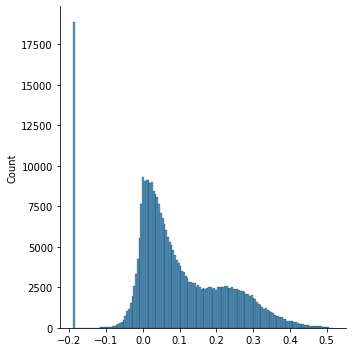

In [147]:
sns.displot(score_texture)

In [178]:
x, y = hs_xy_texture[:, 0], hs_xy_texture[:, 1]
angle = np.arctan2(y,x)
h = np.degrees(angle) % 360.0
h = h / 360

s = np.sqrt(x**2+y**2)
s = np.clip(s, 0, 1)


v = score_texture
vmax = v.max()
v = np.clip(v, 0, vmax)
vmin = v.min()
v = (v-vmin)/(vmax-vmin)

# v = np.ones_like(v)

In [179]:
hsv_texture = np.stack([h, s, v], -1)

In [180]:
import seaborn as sns

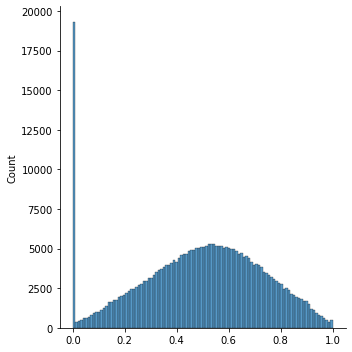

In [181]:
sns.displot(s)

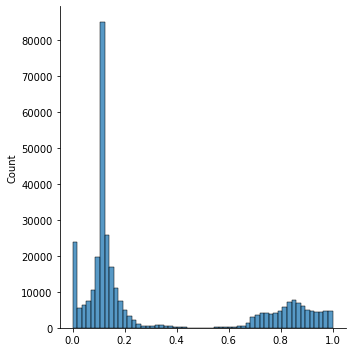

In [182]:
sns.displot(h)

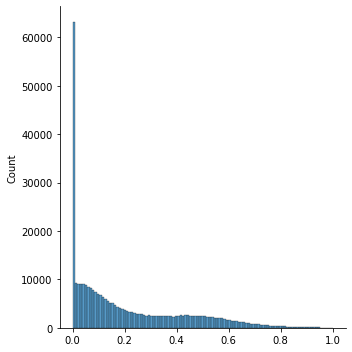

In [183]:
sns.displot(v)

In [184]:
import colorsys

rgb_texture = np.zeros_like(hsv_texture)
for i in range(len(hsv_texture)):
    rgb_texture[i] = colorsys.hsv_to_rgb(*hsv_texture[i])

In [185]:
hsv_texture

array([[0.        , 0.        , 0.        ],
       [0.78841556, 0.70646514, 0.57746003],
       [0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.10714286, 0.27217436, 0.01589702]])

In [186]:
rgb_texture

array([[0.        , 0.        , 0.        ],
       [0.46751335, 0.16950465, 0.57746003],
       [0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.01589702, 0.01435175, 0.01157026]])

In [187]:
np.save('./tmp/rgb_texture.npy', rgb_texture)

In [189]:
np.save('./tmp/raw_texture.npy', texture)